# Neural & Behavioral Modeling - Week 13 (Exercises)
by Your Name (Your Email)

In [8]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [9]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.13.0
No GPU


## 1 Visualizing the latent space of an autoencoder (4 points)

Please train an autoencoder to project MNIST (training) images to a 2D latent space and visualize how these images are organzed in the latent space, as demonstrated in P.20 of model_13_slides.pdf.

<img src="http://fastforwardlabs.github.io/blog-images/miriam/tableau.1493x693.png" width=80%>


### 1.0 The MNIST Data

In [10]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x1277625e0>)

In [17]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
X_train,Y_train=train_set[0],train_set[1]
X_valid,Y_valid=valid_set[0],valid_set[1]
X_test,Y_test=test_set[0],test_set[1]

# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_valid=t.from_numpy(x_valid)
Y_valid=t.from_numpy(y_valid)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_valid=X_valid.cuda()
    Y_valid=Y_valid.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

/var/folders/kd/bdrqt3tj351gf36v20dm1wqr0000gn/T/ipykernel_52587/3705309575.py:4: DeprecationWarning: invalid escape sequence '\>'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
/var/folders/kd/bdrqt3tj351gf36v20dm1wqr0000gn/T/ipykernel_52587/3705309575.py:4: DeprecationWarning: invalid escape sequence '\?'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


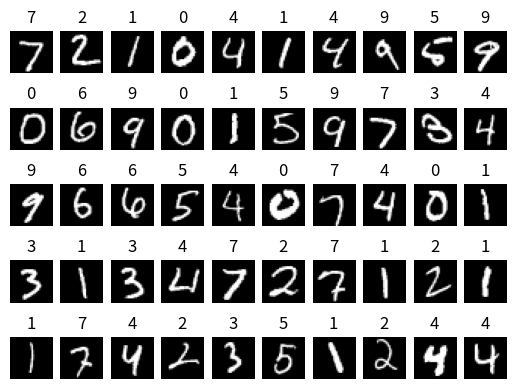

In [18]:
# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

### 1.1 An autoencoder

In [26]:
import torch.nn as nn

# Define the network:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2) # 2-dimensional latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [51]:
model=autoencoder()
print(model)
loss_fn = t.nn.MSELoss(reduction='mean')
learning_rate = 1e-3
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)


### 1.2 Your training (2 points)

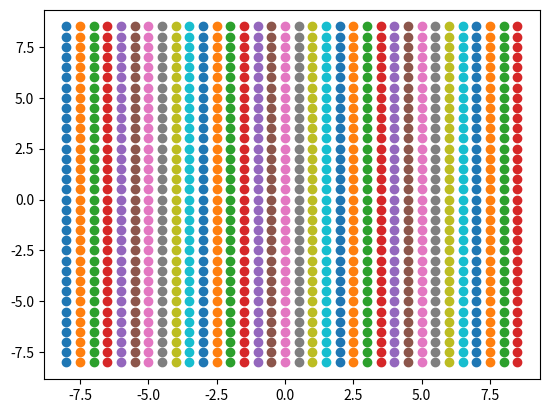

In [82]:
x, y = np.meshgrid(np.arange(-8,9,.5),np.arange(-8,9,.5))
plot(x, y, 'o')

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

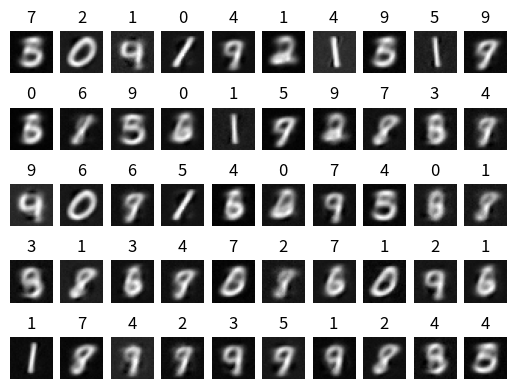

In [56]:
for i in range(1000):
    # Forward pass:
    encode, decode = model(X_train)

    loss = loss_fn(X_train, decode)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % 50 == 0:
        decode = decode.detach().numpy()
        for i in range(50):
            subplot(5,10,i+1)
            imshow(decode[i].reshape([28,28]),cmap='gray');
            title(str(y_test[i]));
            axis('off')

In [ ]:
# Specify batch size
batch_size = 500
n_batch = int(len(X_train)/batch_size)
# Split the training data
X_train_batches = X_train.reshape(n_batch, batch_size, -1) 
Y_train_batches = Y_train.reshape(n_batch, batch_size)

for i in range(51):

    # shuffle batches
    randIndex = t.randperm(n_batch)
    X_train_batches = X_train_batches[randIndex,:,:]
    Y_train_batches = Y_train_batches[randIndex,:]

    for batch in range(len(X_train_batches)):
        # Forward pass:
        Y_pred = model(X_train_batches[batch])
        loss = loss_fn(Y_pred, Y_train_batches[batch])
        
        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass:
        loss.backward()

        # Update the weights using gradient descent:
        optimizer.step()
        
    # Check training accuracy:
    if i % 10 == 0:
        Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])

In [ ]:
# Testing the network:
Y_pred = model(X_test) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test).sum().item()/Y_test.shape[0]
print('Accuracy on all testing samples:',test_acc)

# Visualize results of the first 50 testing samples:
Y_pred = model(X_test[0:50,]) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred[0:50],1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test[0:50]).sum().item()/50
print('Accuracy on the first 50 testing samples:',test_acc)
print('Correct answers:\n',y_test[0:50].reshape([5,10]))

for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(Y_pred[i].item()));
    axis('off')

### 1.3 Your visualization (2 points)

In [ ]:
# Please grid-sample the model 2D latent space and visualize the corresponding decoder outputs here

## 2 Integer Factorization (4 points)

Here we explore the possibilty that a neural network may be able to judge whether an input integer is a prime number or not.

* Computational problem: tell if an input is a prime number 

* Network Input: an integer in binary code (e.g., 0→000000000000000 (15 bits); 1→000000000000001; 2→000000000000010)

* Network Output: 1 unit (1=yes; 0=no)

* Network Architecture: your choice

* Data set: You can enlarge your training and testing data sets, if necessary. Training accuracies and testing accuraces are both informative but of course we care more about the testing ones.

### 2.1 The data set

In [ ]:
from math import sqrt; from itertools import count, islice

def isPrime(n):
    return n > 1 and all(n%i for i in islice(count(2), int(sqrt(n)-1)))

ifPrime=np.vectorize(isPrime)    

x=np.arange(32768) #2^15
y=ifPrime(x).astype(int) 

# Training-testing splits:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Training data:
print(x_train.shape,x_train)
print(y_train.shape,y_train)

# Testing data:
print(x_test.shape,x_train)
print(y_test.shape,y_train)

# Conversion of an integer to its binary code:
format(x_train[0], '015b') # 15-dimensional feature vector

(26214,) [32048 10237 13837 ... 19615  8055 21476]
(26214,) [0 0 0 ... 0 0 0]
(6554,) [32048 10237 13837 ... 19615  8055 21476]
(6554,) [0 0 0 ... 0 0 0]


'111110100110000'

### 2.2 Your computational experiments (2 points)

In [ ]:
# Please train & evaluate your model here.

### 2.3 Your discussion (2 points)

In [ ]:
# Please explain why your model prediction accuracy is better than chance but worse than perfect.